Resuming for funsies

In [9]:
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

# Day 8

In [11]:
width = 25
height = 6

with open('input8') as f:
    image_data = [int(e) for e in f.read().strip()]

In [55]:
nlayers = len(image_data)/(25*6)
assert int(nlayers) == nlayers
nlayers = int(nlayers)

image = np.array(image_data).reshape(nlayers, height, width)
image.shape

(100, 6, 25)

## Part 1

In [56]:
nzeros

array([260, 268, 273, 278, 273, 272, 275, 266, 265, 266, 265, 264, 268,
       267, 269, 273, 255, 274, 271, 265, 261, 262, 255, 266, 257, 251,
       256, 242, 258, 255, 254, 255, 250, 250, 240, 251, 237, 247, 232,
       245, 235, 245, 242, 228, 225, 224, 239, 220, 222, 228, 227, 229,
       219, 234, 221, 222, 228, 224, 217, 213, 209, 221, 204, 193, 213,
       209, 200, 202, 196, 198, 188, 181, 195, 189, 193, 181, 211, 203,
       186, 187, 188, 170, 178, 182, 177, 188, 185, 185, 179, 185, 179,
       172, 178, 171, 184, 174, 164, 187, 160, 149])

In [66]:
nzeros = np.sum(image==0, axis=(1, 2))
idx_minzeros = np.argmin(nzeros)
idx_minzeros

17

In [67]:
minlayer = image[idx_minzeros]
np.sum(minlayer==2)*np.sum(minlayer==1)

1820

## Part 2 

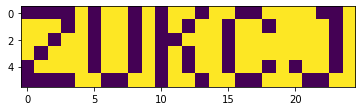

In [78]:
result = image[0].copy()

for layer in image[1:]:
    still_transparent = result == 2
    if np.sum(still_transparent) == 0:
        break
    result[still_transparent] = layer[still_transparent]
black = result==0
plt.imshow(black)

# Day 9

See [Intcode_tester](Intcode_tester.ipynb)

# Day 10

In [20]:
with open('input_10') as f:
    asteroid_map = f.read().strip()

In [62]:
def map_to_array(astmap):
    return np.array([[e=='#' for e in row] for row in astmap.split('\n')]).T

def array_to_map(arr, marker='#'):
    buffer = []
    for row in arr.T:
        for element in row:
            buffer.append(marker if element else '.')
        buffer.append('\n')
    return ''.join(buffer)

## Part 1

In [48]:
test_input = """
.#..#
.....
#####
....#
...##
"""[1:-1]
test_array = map_to_array(test_input)
print(array_to_map(test_array))

# check that indexing convention is consistent
assert test_array[1, 0]
assert test_array[2, 2]
assert not test_array[1, 1]

.#..#
.....
#####
....#
...##



In [51]:
test_asteroids = list(zip(*np.where(test_array)))
test_asteroids

[(0, 2),
 (1, 0),
 (1, 2),
 (2, 2),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 2),
 (4, 3),
 (4, 4)]

Core algorithm for finding if asteroid B blocks view from A:
1. compute v = B-A
2. determine the smallest rational ratio vector w of vy/vx
3. B blocks B + w, B+ 2*w, etc until off the grid

In [69]:
from math import gcd

def make_blockage_map(source_coords, otherasteroid_coords):
    # returns True where they are *not* visible
    max_x = max_y = 0
    for x, y in [source_coords] + otherasteroid_coords:
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y
        
    
    blockage_map = np.zeros((max_x+1, max_y+1), dtype=bool)
    Ax, Ay = source_coords
    
    for Bx, By in otherasteroid_coords:
        dx = Bx - Ax
        dy = By - Ay
        
        vgcd = gcd(dx, dy)
        dx //= vgcd
        dy //= vgcd

        Cx = Bx + dx
        Cy = By + dy
        while 0 <= Cx < blockage_map.shape[0] and 0 <= Cy < blockage_map.shape[1]:
            blockage_map[Cx, Cy] = True
            Cx += dx
            Cy += dy
    
    return blockage_map

blockage1 = make_blockage_map(test_asteroids[0], test_asteroids[1:])
print(array_to_map(blockage1, 'X'))

.....
.....
..XXX
.....
.....



In [72]:
def visible_asteroids(source_coords, otherasteroid_coords):
    blockage_map = make_blockage_map(source_coords, otherasteroid_coords)
    asteroids = np.zeros_like(blockage_map)
    for x, y in otherasteroid_coords:
        asteroids[x, y] = True
    return asteroids & ~blockage_map
visible1 = visible_asteroids(test_asteroids[0], test_asteroids[1:])
print(array_to_map(visible1, '#'))

.#..#
.....
.#...
....#
...##



In [80]:
visible_count = -np.ones(test_array.shape, dtype=int)
for i, ast in enumerate(test_asteroids):
    other_asteroids = test_asteroids.copy()
    other_asteroids.pop(i)
    visible_count[ast[0], ast[1]] = np.sum(visible_asteroids(ast, other_asteroids).ravel())
for row in visible_count.T:
    for element in row:
        print('.' if element==-1 else element, end='')
    print('')

.7..7
.....
67775
....7
...87


Above looks just like the example.

In [96]:
def find_best_asteroid(astmap):
    ast_array = map_to_array(astmap)
    asteroids = list(zip(*np.where(ast_array)))
    
    visible_count = -np.ones(ast_array.shape, dtype=int)
    for i, ast in enumerate(asteroids):
        other_asteroids = asteroids.copy()
        other_asteroids.pop(i)
        visible_count[ast[0], ast[1]] = np.sum(visible_asteroids(ast, other_asteroids).ravel())
        
    bestidx = np.where(np.max(visible_count)==visible_count)
    bestidx = (bestidx[0][0], bestidx[1][0])
        
    return bestidx, visible_count.T

In [100]:
test_map2 = """
......#.#.
#..#.#....
..#######.
.#.#.###..
.#..#.....
..#....#.#
#..#....#.
.##.#..###
##...#..#.
.#....####
"""[1:-1]
result = find_best_asteroid(test_map2)
assert result[0] == (5, 8)
result

((5, 8),
 array([[-1, -1, -1, -1, -1, -1, 30, -1, 30, -1],
        [32, -1, -1, 29, -1, 27, -1, -1, -1, -1],
        [-1, -1, 27, 32, 28, 32, 29, 29, 27, -1],
        [-1, 30, -1, 30, -1, 28, 29, 31, -1, -1],
        [-1, 32, -1, -1, 30, -1, -1, -1, -1, -1],
        [-1, -1, 32, -1, -1, -1, -1, 30, -1, 31],
        [29, -1, -1, 30, -1, -1, -1, -1, 30, -1],
        [-1, 28, 31, -1, 32, -1, -1, 30, 30, 28],
        [30, 32, -1, -1, -1, 33, -1, -1, 29, -1],
        [-1, 27, -1, -1, -1, -1, 30, 32, 31, 25]]))

Real thing:

In [104]:
result = find_best_asteroid(asteroid_map)
result

((17, 22),
 array([[ -1, 255,  -1, ...,  -1,  -1,  -1],
        [ -1, 257,  -1, ..., 259,  -1, 272],
        [250,  -1,  -1, ...,  -1,  -1,  -1],
        ...,
        [ -1,  -1, 249, ...,  -1,  -1,  -1],
        [ -1, 256,  -1, ...,  -1,  -1,  -1],
        [ -1,  -1,  -1, ..., 261, 254,  -1]]))

In [106]:
np.max(result[1])

276

## Part 2 

# Day N

## Part 1

## Part 2 